# Introduction

In [1]:
# Import libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from ipywidgets import *
from datetime import datetime, timedelta
from IPython.display import Image
from matplotlib.dates import DateFormatter

In [2]:
DATA_PATH = 'data/'
BTC_PATH = DATA_PATH + 'bitcoin/'
ETH_PATH = DATA_PATH + 'ethereum/'
HARDWARE_PATH = DATA_PATH+'hardware/'
FIG_PATH = '../../images/'

In [3]:
seconds_in_year = 31536000
hours_in_year = 8760
seconds_in_day = 86400
kWh_to_J = 3600*10**3
W_to_TWh = hours_in_year/(10**12)

std_PUE = {'lower': 1, 'estimate': 1.1, 'upper':1.2}
revenue_percent = 0.60

BTC_block_time = 600
BTC_difficulty_factor = 2**32

ETH_block_time = 15
ETH_difficulty_factor = 1


# Plots
date_form = DateFormatter("%m-%d")

In [4]:
def hashrate_from_difficulty(difficulty):
    return difficulty*BTC_difficulty_factor/BTC_block_time

## Geography 

In [5]:
# US: https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/
# China: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Russia: https://www.mondaq.com/china/oil-gas-electricity/804336/china-electricity-prices-for-industrial-consumers
# Kazakhstan: https://www.globalpetrolprices.com/Kazakhstan/electricity_prices/
# Malaysia: https://www.globalpetrolprices.com/Malaysia/electricity_prices/
# Iran: https://financialtribune.com/articles/energy/97278/rise-in-electricity-and-water-tariffs-in-iran

In [6]:
data = {'location': ['China', 'US', 'Russia', 'Kazakhstan', 'Malaysia','Iran','Canada','Norway','Germany'],
        'share': [66.17, 7.15, 6.43, 5.89, 4.22, 3.67, 0.80, 0.67, 0.5],
        'normal_price': [0.074, 0.0693, 0.041, 0.046, 0.101, 0.07, 0.10, 0.08, 0.2]}
CBECI_geography = pd.DataFrame(data).set_index('location')
CBECI_geography['share'] = CBECI_geography['share']/100 
CBECI_geography['normal_price'] = CBECI_geography['normal_price']/kWh_to_J
CBECI_geography.loc['RoW'] = [1-np.sum(CBECI_geography['share']), 0.084/kWh_to_J]
CBECI_geography

share  normal_price
location                        
China       0.6617  2.055556e-08
US          0.0715  1.925000e-08
Russia      0.0643  1.138889e-08
Kazakhstan  0.0589  1.277778e-08
Malaysia    0.0422  2.805556e-08
Iran        0.0367  1.944444e-08
Canada      0.0080  2.777778e-08
Norway      0.0067  2.222222e-08
Germany     0.0050  5.555556e-08
RoW         0.0450  2.333333e-08

In [7]:
avg_elec_price = np.sum(CBECI_geography.share*CBECI_geography.normal_price)
avg_geography = pd.DataFrame({'share':1, 'normal_price':avg_elec_price}, index=['world'])
avg_geography

share  normal_price
world      1  2.005935e-08

In [8]:
china_data = {'location': ['Xinjiang', 'Sichuan', 'Nei Mongol', 'Yunnan', 'Beijing', 'Zhejiang', 'Shanxi', 'Gansu', 'Guizhou', 'Qinhai'],
             'share': [36.49,9.74,8.22,5.5,1.5,0.82,0.71,0.57,0.28,0.26]}
#CBECI_geography_china = CBECI_geography.append(pd.DataFrame(china_data)).set_index('location').drop('China').sort_values(by='share', ascending=False)

## Functions

In [9]:
def calc_profitability_threshold(data, PUE, elec_price, growth_factor):
    rev_per_hash = data['revenue']*growth_factor/data['hashrate'] #$/h
    return rev_per_hash/(elec_price*PUE)

def is_profitable(hardware, data, PUE, elec_price, growth_factor=1):
    profitability_threshold = calc_profitability_threshold(data, PUE, elec_price, growth_factor)
    # consumption is J/h, if smaller, more efficient
    if hardware['consumption'] < profitability_threshold:
        return True
    else:
        return False
    
def get_profitable_hardware(data, hardware, PUE_dict = std_PUE, bound = 'estimate', PUE_fix = True, elec_price = avg_elec_price, growth_factor = 1):
    if bound == "lower":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['lower'], elec_price),axis=1)]
    elif bound == "upper":
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['upper'], elec_price),axis=1)]
    else:
        prof_hardware = hardware[hardware.apply(lambda x: is_profitable(x, data, PUE_dict['estimate'], elec_price),axis=1)]
    if prof_hardware.empty and PUE_fix:
        prof_hardware = hardware[hardware.consumption == hardware.consumption.min()]
    return prof_hardware

In [10]:
def get_buy_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_on_hardware(hardware):
    return hardware.sort_values(by='consumption').iloc[0]

def get_turn_off_hardware(hardware): 
    return hardware.sort_values(by='consumption', ascending=False).iloc[0]

In [11]:
def calc_consumption(hardware):
    # TODO: bounds
    return np.sum(hardware['on_num']*hardware['hashing_power']*hardware['consumption'])

In [12]:
def replace_hardware(time, data, hardware):
    # If hardware not profitable with double bitcoin price, replace!
    to_replace = hardware[~hardware.apply(lambda x: is_profitable(x, data, std_PUE['estimate'], avg_elec_price, growth_factor = 2), axis=1)]  
    to_replace = to_replace[to_replace['on_num'] >= 1]
    
    if to_replace.empty:
        return hardware
    
    replace_hashrate = np.sum(to_replace['on_num']*to_replace['hashing_power'])
        
    cur_hardware = hardware[hardware.release_date < time]
    prof_hardware = get_profitable_hardware(data, cur_hardware)

    best_hardware = get_buy_hardware(prof_hardware)
    
    #print(best_hardware)
        
    hardware.loc[to_replace.index, 'off_num'] += hardware.loc[to_replace.index, 'on_num']
    hardware.loc[to_replace.index, 'on_num'] = 0

    num_extra = np.ceil(replace_hashrate/best_hardware.hashing_power)
    hardware.loc[best_hardware.name, 'on_num'] += num_extra

    return hardware

# Bitcoin

## Loading history

In [13]:
# https://www.blockchain.com/charts/difficulty
difficulty = pd.read_csv(BTC_PATH+'difficulty.csv')
# https://www.blockchain.com/charts/miners-revenue
revenue = pd.read_csv(BTC_PATH+'miners-revenue.csv')
# https://www.blockchain.com/charts/market-price
price = pd.read_csv(BTC_PATH+'price.csv')

difficulty['Timestamp'] = pd.to_datetime(difficulty['Timestamp'])
revenue['Timestamp'] = pd.to_datetime(revenue['Timestamp'])
price['Timestamp'] = pd.to_datetime(price['Timestamp'])

difficulty = difficulty.rename(columns={'Timestamp': 'timestamp'}).set_index('timestamp')
revenue = revenue.rename(columns={'Timestamp': 'timestamp', 'miners-revenue': 'revenue'}).set_index('timestamp')
price = price.rename(columns={'Timestamp': 'timestamp', 'market-price': 'price'}).set_index('timestamp')

In [14]:
revenue = revenue.groupby(pd.Grouper(freq='W')).mean()
revenue = revenue/seconds_in_day
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()
bitcoin = difficulty.join(revenue).dropna()

In [15]:
price = price.groupby(pd.Grouper(freq='W')).mean()
bitcoin = bitcoin.join(price).dropna()
bitcoin

difficulty     revenue        price
timestamp                                        
2009-01-25  1.000000e+00    0.000000     0.000000
2009-02-01  1.000000e+00    0.000000     0.000000
2009-02-08  1.000000e+00    0.000000     0.000000
2009-02-15  1.000000e+00    0.000000     0.000000
2009-02-22  1.000000e+00    0.000000     0.000000
...                  ...         ...          ...
2020-04-19  1.471520e+13  164.153155  6967.716429
2020-04-26  1.595870e+13  155.823463  7017.877143
2020-05-03  1.595870e+13  164.896564  7640.203810
2020-05-10  1.605610e+13  205.533526  8896.620000
2020-05-17  1.610480e+13  174.089559  9288.403571

[589 rows x 3 columns]

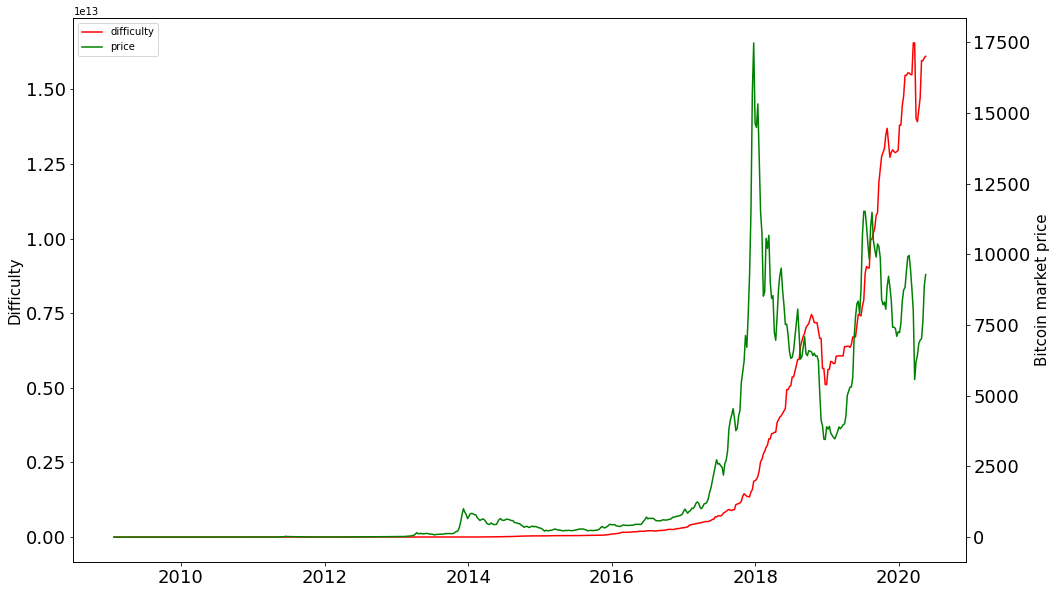

In [16]:
fig, ax1 = plt.subplots(figsize=(16,10))

ln1 = ax1.plot(bitcoin['difficulty'],color="red", label="difficulty")

ax2 = ax1.twinx()

ln2 = ax2.plot(bitcoin['price'], color="green", label="price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

#ax2.legend(loc='upper left')

ax1.set_ylabel('Difficulty', fontsize = 15)
ax2.set_ylabel('Bitcoin market price', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.show()

In [17]:
first_halve = datetime(2012, 11, 1)
second_halve = datetime(2016, 7, 1)
third_halve = datetime(2020, 5, 13)


asic = datetime(2013,1,1)
gpu = datetime(2010,10,1)
fpga = datetime(2011, 6, 1)

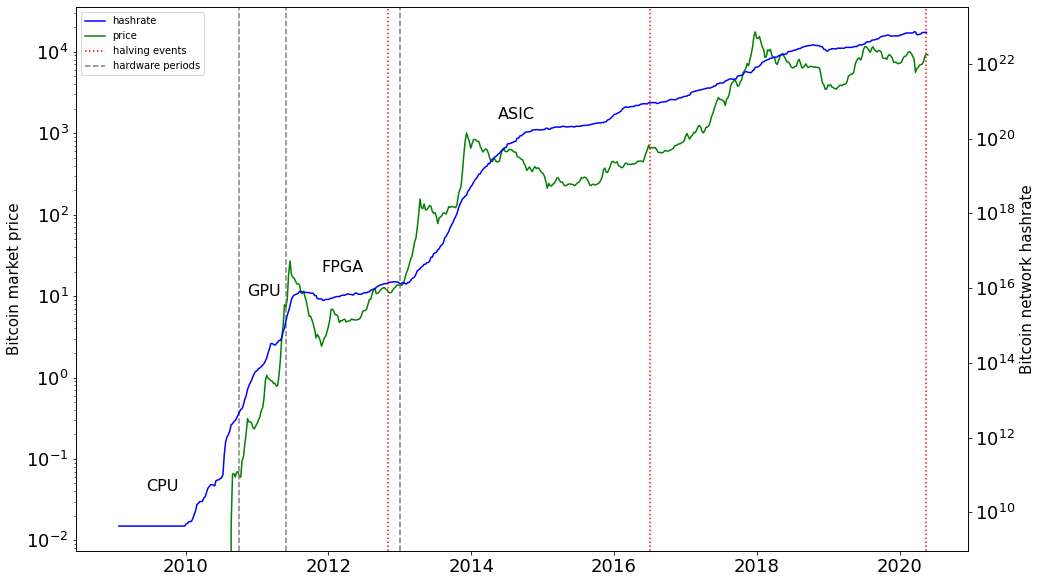

In [18]:
fig, ax = plt.subplots(figsize=(16,10))

ln1 = ax.plot(price['price'], color="green", label="price")
#plt.plot(first_halve)

ax2 = ax.twinx()
ln1 = ax2.plot(bitcoin['difficulty']*2**32,color="blue", label="hashrate")

h1 = ax.axvline(first_halve, color='red', label='halving events', ls=':')
ax.axvline(second_halve, color='red', ls=':')
ax.axvline(third_halve, color='red', ls=':')

h2 = ax.axvline(gpu, color='grey', label='hardware periods', ls='--')
ax.axvline(fpga, color='grey', ls='--')
ax.axvline(asic, color='grey', ls='--')

ax.text(datetime(2009,6,15),0.04, 'CPU', fontsize=16)
ax.text(gpu + timedelta(days=40),10, 'GPU', fontsize=16)
ax.text(fpga + timedelta(days=180),20, 'FPGA', fontsize=16)
ax.text(asic + timedelta(days=500),1500, 'ASIC', fontsize=16)


ln3 = [h1, h2]

ax.set_yscale('log')
ax2.set_yscale('log')

# added these three lines
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

ax.set_ylabel('Bitcoin market price', fontsize = 15)
ax2.set_ylabel('Bitcoin network hashrate', fontsize = 15)
plt.savefig('BTC_hashrate_price.png')
plt.show()

## Simulate

In [19]:
SHA256_hardware = pd.read_csv(HARDWARE_PATH+'SHA256_hardware_clean.csv',index_col=0)
# Initialisation
hardware = SHA256_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware['efficiency'] = 1/hardware['consumption']
hardware.sort_values(by='consumption')

name release_date   consumption  \
82  Bitmain Antminer S19 Pro (110Th)   2020-05-01  2.955000e-11   
83       Bitmain Antminer S19 (95Th)   2020-05-01  3.421000e-11   
80           MicroBT Whatsminer M30S   2020-04-01  3.800000e-11   
57   Bitmain Antminer S17 Pro (50Th)   2019-04-01  3.950000e-11   
56   Bitmain Antminer S17 Pro (53Th)   2019-04-01  3.951000e-11   
..                               ...          ...           ...   
22         Bitmain Antminer V9 (4Th)   2018-03-01  2.567500e-10   
4             Bitmain Antminer S7-LN   2016-06-01  2.581500e-10   
2                Bitmain Antminer S7   2015-09-01  2.733600e-10   
1                Bitmain Antminer S5   2014-12-01  5.108200e-10   
0                Bitmain Antminer S3   2014-07-01  7.656900e-10   

    hashing_power    efficiency  
82   1.100000e+14  3.384095e+10  
83   9.500000e+13  2.923122e+10  
80   8.600000e+13  2.631579e+10  
57   5.000000e+13  2.531646e+10  
56   5.300000e+13  2.531005e+10  
..            ...           ...  
22   4.000000e+12  3.894839e+09  
4    3.000000e+12  3.873717e+09  
2    5.000000e+12  3.658180e+09  
1    1.000000e+12  1.957637e+09  
0    0.000000e+00  1.306012e+09  

[84 rows x 5 columns]

In [20]:
# Select only from first hardware available in dataset
bitcoin = bitcoin[bitcoin.index > SHA256_hardware.loc[0,'release_date']].copy()

# Difficulty to hashrate
bitcoin['hashrate'] = bitcoin['difficulty'].apply(lambda x: hashrate_from_difficulty(x))

In [21]:
hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
consumption_lower = []
for time, data in bitcoin.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_buy_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = prof_hardware[prof_hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    #hardware = replace_hardware(time, data, hardware)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  
    
    best_hardware = get_buy_hardware(cur_hardware)
    consumption_lower.append(cur_hashrate*best_hardware.consumption*W_to_TWh)
    
bitcoin['consumption'] = consumption
bitcoin['consumption_lower'] = consumption_lower

<ipython-input-21-890ab3b184f0>:37: RuntimeWarning: divide by zero encountered in double_scalars
  num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
<ipython-input-21-890ab3b184f0>:41: RuntimeWarning: invalid value encountered in double_scalars
  cur_hashrate += num_extra*best_hardware.hashing_power
<ipython-input-21-890ab3b184f0>:49: RuntimeWarning: invalid value encountered in double_scalars
  min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)


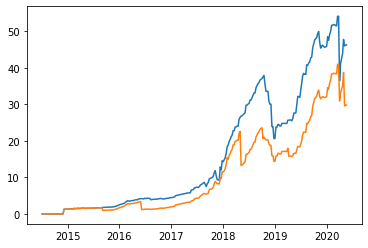

In [22]:
plt.plot(bitcoin.index,bitcoin.consumption)
plt.plot(bitcoin.index,bitcoin.consumption_lower)
plt.show()

In [23]:
hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)]

name release_date   consumption  \
1                Bitmain Antminer S5   2014-12-01  5.108200e-10   
2                Bitmain Antminer S7   2015-09-01  2.733600e-10   
3       Bitmain Antminer S9 (11.5Th)   2016-06-01  9.800000e-11   
5                Bitmain Antminer R4   2017-02-01  9.713000e-11   
20                    Ebang Ebit E10   2018-02-01  9.167000e-11   
26              ASICminer 8 Nano Pro   2018-05-01  5.263000e-11   
44                  Ebang Ebit E11++   2018-10-01  4.500000e-11   
57   Bitmain Antminer S17 Pro (50Th)   2019-04-01  3.950000e-11   
80           MicroBT Whatsminer M30S   2020-04-01  3.800000e-11   
82  Bitmain Antminer S19 Pro (110Th)   2020-05-01  2.955000e-11   

    hashing_power    efficiency    off_num     on_num  
1    1.000000e+12  1.957637e+09   388384.0        1.0  
2    5.000000e+12  3.658180e+09   205256.0        0.0  
3    1.200000e+13  1.020408e+10   126665.0        0.0  
5    9.000000e+12  1.029548e+10  1687660.0        0.0  
20   1.800000e+13  1.090869e+10   121775.0   434527.0  
26   7.600000e+13  1.900057e+10        0.0   303469.0  
44   4.400000e+13  2.222222e+10        0.0   184700.0  
57   5.000000e+13  2.531646e+10        0.0  1326471.0  
80   8.600000e+13  2.631579e+10        0.0   103504.0  
82   1.100000e+14  3.384095e+10        0.0     9508.0

In [24]:
(hardware.loc[56, 'on_num'] + hardware.loc[57, 'on_num']) / np.sum(hardware['on_num'])

0.5615452675071333

In [25]:
bitcoin.iloc[len(bitcoin)-1]

difficulty           1.610480e+13
revenue              1.740896e+02
price                9.288404e+03
hashrate             1.152826e+20
consumption          4.630079e+01
consumption_lower    2.984185e+01
Name: 2020-05-17 00:00:00, dtype: float64

In [26]:
np.sum(hardware['on_num']*hardware['hashing_power'])

1.15282705e+20

## Extrapolation

In [27]:
import matplotlib.dates as mdates

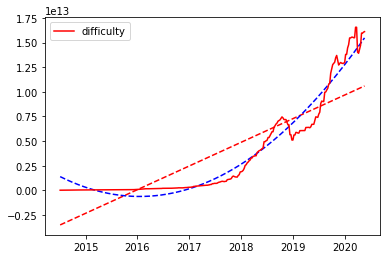

In [28]:
x = mdates.date2num(bitcoin.index)

z = np.polyfit(x,bitcoin['difficulty'], 1)

p = np.poly1d(z)
plt.plot(x,p(x),"r--")

z2 = np.polyfit(x,bitcoin['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

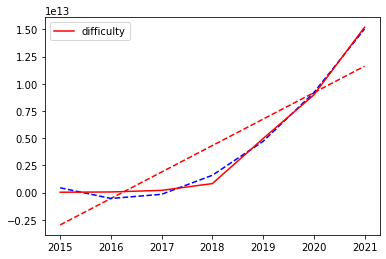

In [992]:
bitcoin_year = bitcoin.groupby(pd.Grouper(freq='Y')).mean()
x = mdates.date2num(bitcoin_year.index)

z = np.polyfit(x,bitcoin_year['difficulty'], 1)

p = np.poly1d(z)
plt.plot(x,p(x),"r--")

z2 = np.polyfit(x,bitcoin_year['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin_year['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

In [993]:
for i in range(len(bitcoin_year)):
    print(bitcoin_year.iloc[i]['hashrate']/bitcoin_year.iloc[i-1]['hashrate'])

0.0019861852921524694
1.7872380320308643
3.744803846524828
4.071251007947607
6.027620036927426
1.8074622793840696
1.6959997232768518


In [994]:
bitcoin

difficulty     revenue        price      hashrate  consumption  \
timestamp                                                                      
2014-07-06  1.681846e+10   33.373953   598.955714  1.203912e+17     0.807846   
2014-07-13  1.681846e+10   31.709518   631.147619  1.203912e+17     0.807846   
2014-07-20  1.733632e+10   33.226293   626.760000  1.240982e+17     0.832720   
2014-07-27  1.780303e+10   33.381070   625.332143  1.274390e+17     0.855137   
2014-08-03  1.873644e+10   31.599697   599.566667  1.341207e+17     0.899974   
...                  ...         ...          ...           ...          ...   
2020-04-19  1.471520e+13  164.153155  6967.716429  1.053355e+20    43.809593   
2020-04-26  1.595870e+13  155.823463  7017.877143  1.142368e+20    47.916353   
2020-05-03  1.595870e+13  164.896564  7640.203810  1.142368e+20    46.126413   
2020-05-10  1.605610e+13  205.533526  8896.620000  1.149340e+20    46.367676   
2020-05-17  1.610480e+13  174.089559  9288.403571  1.152826e+20    46.488292   

            consumption_lower  
timestamp                      
2014-07-06           0.807846  
2014-07-13           0.807846  
2014-07-20           0.832720  
2014-07-27           0.855137  
2014-08-03           0.899974  
...                       ...  
2020-04-19          36.448191  
2020-04-26          40.299249  
2020-05-03          39.528228  
2020-05-10          39.769490  
2020-05-17          39.890106  

[305 rows x 6 columns]

### Consumption

In [995]:
# Koomey's law
start_hardware = hardware.loc[0]
efficiency = 0
intervals = 0
for i in range(6):
    cur_hardware = hardware.loc[i]
    efficiency += cur_hardware.efficiency
    intervals += (cur_hardware.release_date-start_hardware.release_date).days

In [999]:
intervals = intervals/6
efficiency = efficiency/6

In [1000]:
start_date = start_hardware.release_date+timedelta(days=intervals)

In [1007]:
"""
Average over first hardware
"""
def n(t, efficiency, start_date):
    n_0 = efficiency
    t_delta = (t - start_date).days/365
    return n_0*(1.27**t_delta)
# Create date
days_future = 365*6
base = start_hardware.release_date
date_list = [base + timedelta(days=x) for x in range(days_future)]
hardware_consumption_pred = list(map(lambda x: n(x, efficiency, start_date), date_list))

In [928]:
# Koomey's law
start_hardware = hardware.loc[3]
def n(start_hardware, t):
    n_0 = start_hardware.efficiency
    start_date = start_hardware.release_date
    t_delta = (t - start_date).days/365
    return n_0*(1.27**t_delta)

# Create date
days_future = 365*4
base = start_hardware.release_date
date_list = [base + timedelta(days=x) for x in range(days_future)]
hardware_consumption_pred = list(map(lambda x: n(start_hardware, x), date_list))

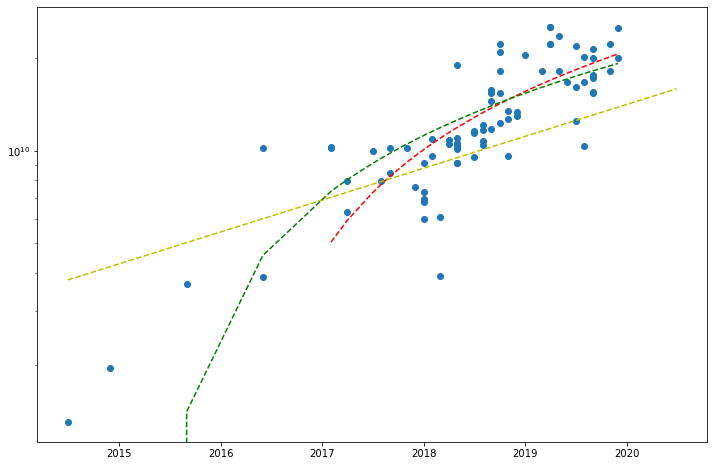

In [1008]:
outliers = True
plt.figure(figsize=(12,8))

hardware_new = hardware[hardware.release_date > datetime(2017,1,1)]

x = mdates.date2num(hardware_new.release_date)
z = np.polyfit(x, hardware_new['efficiency'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.plot(date_list, hardware_consumption_pred, "y--")


if outliers:
    x2 = mdates.date2num(hardware.release_date)
    z2 = np.polyfit(x2,hardware['efficiency'], 1)
    p2 = np.poly1d(z2)
    plt.plot(x2,p2(x2),"g--")
    plt.scatter(hardware['release_date'], hardware['efficiency'])
else :
    plt.scatter(hardware_new['release_date'], hardware_new['efficiency'])
plt.yscale('log')
plt.show()

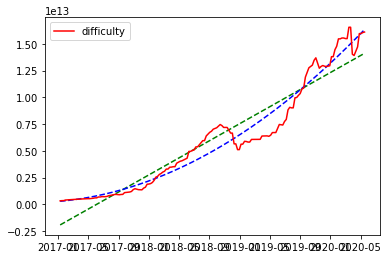

In [900]:
bitcoin_new = bitcoin[bitcoin.index > datetime(2017,1,1)]

x = mdates.date2num(bitcoin_new.index)
z = np.polyfit(x,bitcoin_new['difficulty'], 1)
p = np.poly1d(z)
plt.plot(x,p(x),"g--")

z2 = np.polyfit(x,bitcoin_new['difficulty'], 2)
p2 = np.poly1d(z2)
plt.plot(x,p2(x),"b--")

plt.plot(bitcoin_new['difficulty'],color="red", label="difficulty")
plt.legend()
plt.show()

In [726]:
bitmain = hardware[hardware['name'].apply(lambda x: 'Bitmain' in x or 'Antminer' in x)]

### Hashrate vs efficienty gain

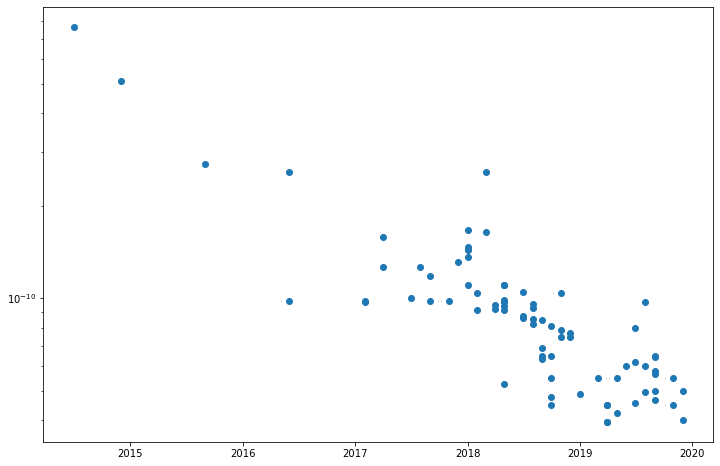

In [727]:
plt.figure(figsize=(12,8))
plt.scatter(hardware['release_date'], hardware['consumption'])
plt.yscale('log')
plt.show()

In [728]:
def get_most_efficient(hardware, before):
    hardware = hardware[hardware.release_date < before]
    return hardware.sort_values(by='consumption').iloc[0]['consumption']

In [729]:
bitcoin['hardware_consumption'] = bitcoin.apply(lambda x: get_most_efficient(hardware, x.name), axis=1)

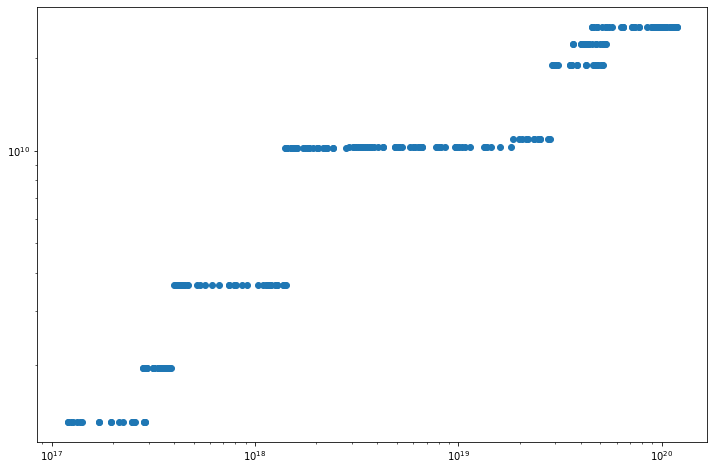

In [730]:
plt.figure(figsize=(12,8))
plt.scatter(bitcoin['hashrate'], 1/bitcoin['hardware_consumption'])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [731]:
def to_end_of_week(date):
    return date-timedelta(days=date.weekday())+ timedelta(days=6)

# To end of week like bitcoin
hardware['release_date'] = hardware['release_date'].apply(lambda x: to_end_of_week(x))
# Add hashrate on release day
hardware['cur_hashrate'] = hardware['release_date'].apply(lambda x: bitcoin.loc[x, 'hashrate'])
hardware

name release_date   consumption  hashing_power  \
0            Bitmain Antminer S3   2014-07-06  7.660000e-10   4.780000e+11   
1            Bitmain Antminer S5   2014-12-07  5.110000e-10   1.000000e+12   
2            Bitmain Antminer S7   2015-09-06  2.730000e-10   5.000000e+12   
3   Bitmain Antminer S9 (11.5Th)   2016-06-05  9.800000e-11   1.200000e+13   
4         Bitmain Antminer S7-LN   2016-06-05  2.580000e-10   3.000000e+12   
..                           ...          ...           ...            ...   
74       Canaan AvalonMiner 1047   2019-09-01  6.430000e-11   3.700000e+13   
75         Bitmain Antminer S17e   2019-11-03  4.500000e-11   6.400000e+13   
76        Bitmain Antminer T17e    2019-11-03  5.500000e-11   5.300000e+13   
77         Bitmain Antminer S17+   2019-12-01  4.000000e-11   7.300000e+13   
78         Bitmain Antminer T17+   2019-12-01  5.000000e-11   6.400000e+13   

      efficiency   off_num  on_num  cur_hashrate  
0   1.305483e+09  603513.0     0.0  1.203912e+17  
1   1.956947e+09   99905.0     0.0  2.874317e+17  
2   3.663004e+09  212536.0     0.0  3.980514e+17  
3   1.020408e+10  126721.0     0.0  1.426731e+18  
4   3.875969e+09       0.0     0.0  1.426731e+18  
..           ...       ...     ...           ...  
74  1.555210e+10       0.0     0.0  7.409439e+19  
75  2.222222e+10       0.0     0.0  9.800757e+19  
76  1.818182e+10       0.0     0.0  9.800757e+19  
77  2.500000e+10       0.0     0.0  9.286578e+19  
78  2.000000e+10       0.0     0.0  9.286578e+19  

[79 rows x 8 columns]

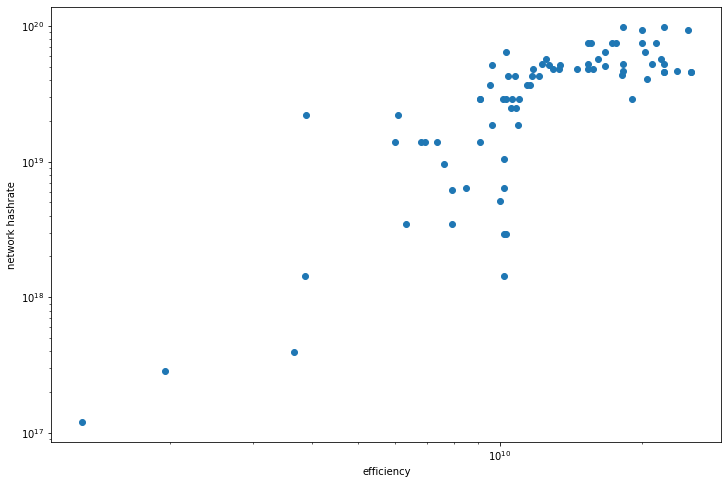

In [732]:
plt.figure(figsize=(12,8))
plt.scatter(1/hardware['consumption'], hardware['cur_hashrate'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('efficiency')
plt.ylabel('network hashrate')
plt.show()

## Hashrate predictor

We start from moment that first ASICs came into existence 

In [733]:
from dateutil.relativedelta import relativedelta

In [762]:
startdate = hardware.loc[0, 'release_date'] - timedelta(days=1)

In [763]:
startdate

Timestamp('2014-07-05 00:00:00')

In [764]:
# consumption
def n(n0, t):
    year_delta = (t - startdate).days/365
    return n0/(1.27*year_delta)
#n(datetime(2019,12,1))

In [765]:
def gamma(t):
    rew0 = 25
    second_halve = datetime(2016,7,1) 
    if t < second_halve:
        return rew0
    else:
        year_delta = (t - second_halve).days/365
        rew = rew0/2**(np.floor(year_delta/4)+1)
        return rew
#gamma(datetime(2020,8,13))

In [766]:
n0 = hardware.loc[0, 'consumption']
def H(x,t):
    return gamma(t)*x/(BTC_block_time*n(n0,t)*std_PUE['estimate']*avg_elec_price)
#H(9000, datetime.now())

In [767]:
#Image(FIG_PATH+"compound_interest.png")
# n = 1
# t per year
def price_future(P, r, t):
    return P*(1 + r)**(t/365)

In [811]:
# Create date
extra_start = 1
days_future = 365*8+extra_start
base = bitcoin.index[len(bitcoin.index)-extra_start]
date_list = [base + timedelta(days=x) for x in range(days_future)]

# Create prices
last_price = bitcoin.price[len(bitcoin.price)-1]
prices = [price_future(last_price, 0.10, t) for t in range(1,len(date_list)+1)]

# Consumption
n_start = hardware.sort_values(by='consumption').iloc[0].consumption
hardware_consumption = [n_start*(1.27)**(t/365) for t in range(1,len(date_list)+1)]

bitcoin_future = pd.DataFrame({'time' : date_list, 'price': prices, 'hardware_consumption':hardware_consumption})

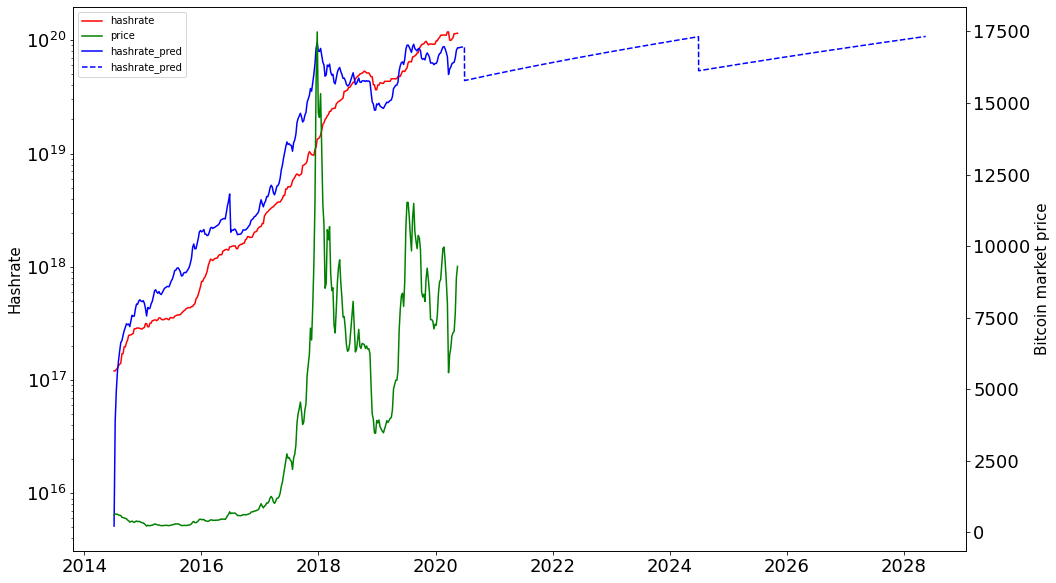

In [812]:
fig, ax1 = plt.subplots(figsize=(16,10))

ln1 = ax1.plot(bitcoin['hashrate'],color="red", label="hashrate")

#t = bitcoin.index
bitcoin['hashrate_pred'] = bitcoin.apply(lambda x: H(x.price, x.name),axis=1)
ln3 = ax1.plot(bitcoin['hashrate_pred'], color="blue", label="hashrate_pred")

t2 = bitcoin_future.time
bitcoin_future['hashrate'] = bitcoin_future.apply(lambda x: H(x.price, x.time),axis=1)
ln4 = ax1.plot(t2,bitcoin_future['hashrate'], '--',color="blue", label="hashrate_pred")


ax2 = ax1.twinx()

ln2 = ax2.plot(bitcoin['price'], color="green", label="price")

lns = ln1+ln2+ln3+ln4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

#ax2.legend(loc='upper left')

ax1.set_yscale('log')
ax1.set_ylabel('Hashrate', fontsize = 15)
ax2.set_ylabel('Bitcoin market price', fontsize = 15)

ax1.tick_params(axis="x", labelsize=18)
ax1.tick_params(axis="y", labelsize=18)
ax2.tick_params(axis="y", labelsize=18)

plt.show()

In [784]:
hardware

name release_date   consumption  hashing_power  \
0            Bitmain Antminer S3   2014-07-06  7.660000e-10   4.780000e+11   
1            Bitmain Antminer S5   2014-12-07  5.110000e-10   1.000000e+12   
2            Bitmain Antminer S7   2015-09-06  2.730000e-10   5.000000e+12   
3   Bitmain Antminer S9 (11.5Th)   2016-06-05  9.800000e-11   1.200000e+13   
4         Bitmain Antminer S7-LN   2016-06-05  2.580000e-10   3.000000e+12   
..                           ...          ...           ...            ...   
74       Canaan AvalonMiner 1047   2019-09-01  6.430000e-11   3.700000e+13   
75         Bitmain Antminer S17e   2019-11-03  4.500000e-11   6.400000e+13   
76        Bitmain Antminer T17e    2019-11-03  5.500000e-11   5.300000e+13   
77         Bitmain Antminer S17+   2019-12-01  4.000000e-11   7.300000e+13   
78         Bitmain Antminer T17+   2019-12-01  5.000000e-11   6.400000e+13   

      efficiency   off_num  on_num  cur_hashrate  
0   1.305483e+09  603513.0     0.0  1.203912e+17  
1   1.956947e+09   99905.0     0.0  2.874317e+17  
2   3.663004e+09  212536.0     0.0  3.980514e+17  
3   1.020408e+10  126721.0     0.0  1.426731e+18  
4   3.875969e+09       0.0     0.0  1.426731e+18  
..           ...       ...     ...           ...  
74  1.555210e+10       0.0     0.0  7.409439e+19  
75  2.222222e+10       0.0     0.0  9.800757e+19  
76  1.818182e+10       0.0     0.0  9.800757e+19  
77  2.500000e+10       0.0     0.0  9.286578e+19  
78  2.000000e+10       0.0     0.0  9.286578e+19  

[79 rows x 8 columns]

### Electricity consumption

In [804]:
def lower_bound(date, hardware, hashrate):
    cur_hardware = hardware[hardware.release_date <= date]
    best_hardware = get_buy_hardware(cur_hardware)
    return hashrate*best_hardware['consumption']*W_to_TWh

In [805]:
bitcoin['consumption_pred'] = bitcoin.apply(lambda x: lower_bound(x.name, hardware,x.hashrate_pred),axis=1)

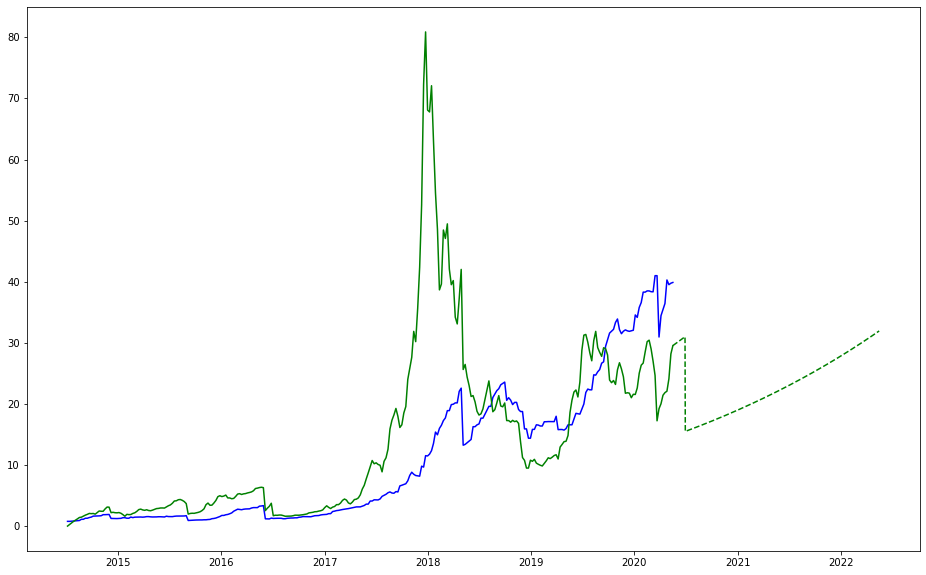

In [806]:
plt.subplots(figsize=(16,10))



plt.plot(bitcoin['consumption_lower'],color="blue", label="consumption (TWh/year)")
plt.plot(bitcoin['consumption_pred'],color="green", label="consumption (TWh/year)")


t2 = bitcoin_future.time
plt.plot(t2,bitcoin_future['energy_consumption'], '--',color="green", label="consumption_pred")

plt.show()

# Ethereum

In [65]:
difficulty = pd.read_csv(ETH_PATH+'difficulty.csv')
reward = pd.read_csv(ETH_PATH+'reward.csv')
price = pd.read_csv(ETH_PATH+'price.csv')

difficulty = difficulty.drop(columns='UnixTimeStamp')
difficulty.columns = ['date', 'value']
reward.columns = ['date', 'reward']
price.columns = ['date', 'price']

In [66]:
for data in [difficulty, reward, price]:
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

In [67]:
difficulty = difficulty.groupby(pd.Grouper(freq='W')).mean()*10**12 # difficulty given in T per block
reward = reward.groupby(pd.Grouper(freq='W')).mean()
price = price.groupby(pd.Grouper(freq='W')).mean()
revenue = reward.join(price)
revenue['revenue'] = revenue['reward']*revenue['price']/seconds_in_day
revenue = revenue[['revenue']]

ethereum = revenue.join(difficulty)
ethereum.columns = ['revenue', 'difficulty']

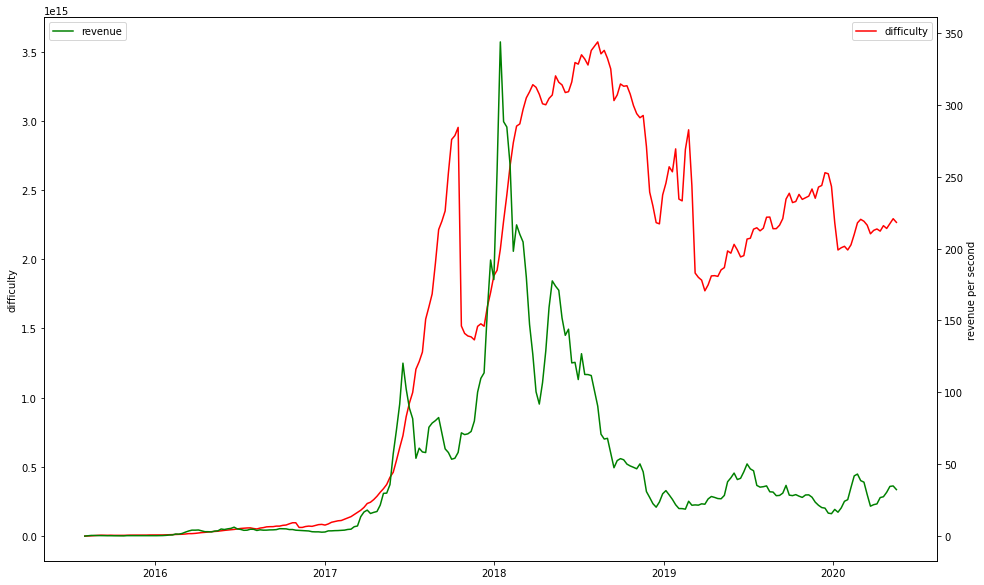

In [68]:
fig, ax1 = plt.subplots(figsize=(16,10))
ax1.plot(ethereum['difficulty'],color="red", label="difficulty")
ax1.legend()
ax1.set_ylabel('difficulty')
ax2 = ax1.twinx()
ax2.plot(ethereum['revenue'], color="green", label="revenue")
ax2.legend(loc='upper left')
ax2.set_ylabel('revenue per second')
plt.show()

In [69]:
ethash_hardware = pd.read_csv(HARDWARE_PATH+'Ethash_hardware_clean.csv',index_col=0)
# Initialisation
hardware = ethash_hardware[['name', 'release_date', 'consumption', 'hashing_power']].copy()
hardware['release_date'] = pd.to_datetime(hardware['release_date'])
hardware[:4]

name release_date  consumption  hashing_power
0      Radeon HD 7870   2012-03-19     0.000017       10000000
1     GeForce GTX 680   2012-03-22     0.000013       15000000
2  GeForce GTX 660 Ti   2012-08-16     0.000013       12000000
3  GeForce GTX 650 Ti   2012-09-10     0.000011       10000000

In [70]:
# Select only from first hardware available in dataset
ethereum = ethereum[ethereum.index > ethash_hardware.loc[0,'release_date']]

# Difficulty to hashrate
ethereum['hashrate'] = ethereum['difficulty']*1/ETH_block_time

In [73]:
hardware['off_num'] = 0
hardware['on_num'] = 0

cur_hashrate = 0
consumption = []
for time, data in ethereum.iterrows():
    cur_hardware = hardware[hardware.release_date < time]
    hashrate_difference = data.hashrate - cur_hashrate
    if hashrate_difference > 0:
        # Network hashrate has increased, turn on/buy devices
        prof_hardware = get_profitable_hardware(data, cur_hardware)
        off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
                
        while cur_hashrate < data.hashrate and (not off_hardware.empty):
            
            best_off_hardware = get_turn_on_hardware(off_hardware)
            
            # Everything gets turned on OR the part needed for hashrate difference gets turned on
            extra_hashing_power = min(best_off_hardware.off_num*best_off_hardware.hashing_power, hashrate_difference)
            
            num_to_on = extra_hashing_power/best_off_hardware.hashing_power
            
            hardware.loc[best_off_hardware.name, 'on_num'] += num_to_on
            hardware.loc[best_off_hardware.name, 'off_num'] -= num_to_on
            
            cur_hashrate += extra_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            off_hardware = prof_hardware[prof_hardware['off_num'] >= 1]
            
        if off_hardware.empty and cur_hashrate < data.hashrate:
            # Have to buy new hardware. Buy entire difference in hashrate from get_next_hardware
            best_hardware = get_buy_hardware(prof_hardware)
            
            num_extra = np.ceil(hashrate_difference/best_hardware.hashing_power)
            
            hardware.loc[best_hardware.name, 'on_num'] += num_extra
            
            cur_hashrate += num_extra*best_hardware.hashing_power
                
    elif hashrate_difference < 0:
        # Network hashrate has decreased, turn off devices
        on_hardware = hardware[hardware['on_num'] >= 1]
        while cur_hashrate > data.hashrate:            
            worst_on_hardware = get_turn_off_hardware(on_hardware)
        
            min_hashing_power = min(worst_on_hardware.on_num*worst_on_hardware.hashing_power, -hashrate_difference)
            
            num_to_off = np.floor(min_hashing_power/worst_on_hardware.hashing_power)
            
            hardware.loc[worst_on_hardware.name, 'on_num'] -= num_to_off
            hardware.loc[worst_on_hardware.name, 'off_num'] += num_to_off
            
            cur_hashrate -= min_hashing_power
            
            # Refresh with new values
            prof_hardware = hardware.loc[prof_hardware.index]
            on_hardware = prof_hardware[prof_hardware['on_num'] >= 1]
    else:
        #print('hashrate_difference = 0')
        pass
    hardware = replace_hardware(time, data, hardware)
    cur_hashrate = np.sum(hardware['on_num']*hardware['hashing_power'])
    consumption.append(calc_consumption(hardware)*W_to_TWh)  

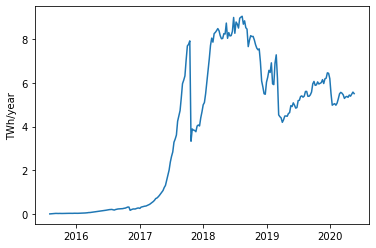

In [74]:
plt.plot(ethereum.index,consumption)
plt.ylabel('TWh/year')
plt.show()

In [75]:
hardware[(hardware['on_num'] > 0) | (hardware['off_num'] > 0)]

name release_date  consumption  hashing_power  \
17  GeForce GTX Titan X   2015-03-17     0.000006       40000000   
27        Radeon Rx 480   2016-01-06     0.000006       25000000   
31     GeForce GTX 1060   2016-08-18     0.000005       24000000   
32   Radeon GTX 1050 Ti   2016-10-25     0.000005       15000000   
37        Radeon RX 550   2017-04-20     0.000005       11000000   
42  GeForce GTX 1070 Ti   2017-02-11     0.000005       32000000   
43          GTX Titan V   2017-12-13     0.000003       77000000   

         off_num        on_num  
17  1.493700e+04  0.000000e+00  
27  1.361640e+05  0.000000e+00  
31  1.475207e+05  3.115079e-01  
32  2.420000e+02  0.000000e+00  
37  6.297082e+06  9.993606e+06  
42  3.145870e+05  0.000000e+00  
43  0.000000e+00  5.344450e+05

In [76]:
ethereum.iloc[len(ethereum)-1]

revenue       3.235190e+01
difficulty    2.266229e+15
hashrate      1.510819e+14
Name: 2020-05-17 00:00:00, dtype: float64

In [77]:
np.sum(hardware['on_num']*hardware['hashing_power'])

151081939999999.97

In [78]:
ethereum.loc['2020-05-17']

revenue       3.235190e+01
difficulty    2.266229e+15
hashrate      1.510819e+14
Name: 2020-05-17 00:00:00, dtype: float64